In [3]:
# Inizializziamo la nostra applicazione Spark
import findspark

location = findspark.find()
findspark.init(location)

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder.appName("Clustering K-means di IRIS").getOrCreate()

24/05/03 10:25:29 WARN Utils: Your hostname, deeplearning resolves to a loopback address: 127.0.1.1; using 147.163.26.113 instead (on interface enp6s0)
24/05/03 10:25:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/05/03 10:25:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# SparkFiles consente la lettura di file esterni
from pyspark import SparkFiles

data_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/iris.scale"

# Aggiungiamo la url nel context della nostra spark application
spark.sparkContext.addFile(data_url)

# Leggiamo i dati dalla url
irisdf = spark.read.format('libsvm').option('numFeatures','4')\
              .load('file://'+SparkFiles.get('iris.scale'))
              
# mostriamo il dataframe
irisdf.show()

# mostriamo anche il dato grezzo e lo schema
print(irisdf.collect()[0])

irisdf.schema.fields

24/05/03 10:40:12 WARN SparkContext: The path https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/iris.scale has been added already. Overwriting of added paths is not supported in the current version.


+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,2,3],[-0.77...|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-1....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
+-----+--------------------+
only showing top 20 rows



Row(label=1.0, features=SparseVector(4, {0: -0.5556, 1: 0.25, 2: -0.8644, 3: -0.9167}))


[StructField('label', DoubleType(), True),
 StructField('features', VectorUDT(), True)]

In [6]:
# trasformiamo il dataframe inserendo una label intera
irisdf = irisdf.withColumn('label',irisdf['label'].cast('integer'))

# mostriamo il dataframe
irisdf.show()

# mostriamo anche il dato grezzo e lo schema
print(irisdf.collect()[0])

irisdf.schema.fields

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,2,3],[-0.77...|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-1....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
+-----+--------------------+
only showing top 20 rows

Row(label=1, features=SparseVector(4, {0: -0.5556, 1: 0.25, 2: -0.8644, 3: -0.9167}))


[StructField('label', IntegerType(), True),
 StructField('features', VectorUDT(), True)]

In [7]:
# Eseguiamo l'analisi PCA del nostro data set
from pyspark.ml.feature import PCA
from pyspark.ml.tuning import ParamGridBuilder

# Inizializziamo la PCA
pca = PCA(inputCol='features')

# creiamo la lista dei valori di dimensioni da provare
dimensions = ParamGridBuilder().addGrid(pca.k,[2,3,4]).build()

# Creiamo la lista dei modelli addestrati sul data set
models = list(pca.fitMultiple(irisdf, dimensions))

models

24/05/03 11:22:55 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/05/03 11:22:55 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


[(0, PCAModel: uid=PCA_df9264d43913, k=2),
 (1, PCAModel: uid=PCA_df9264d43913, k=3),
 (2, PCAModel: uid=PCA_df9264d43913, k=4)]

In [8]:
# Generiamo i data set trasformati secondo le diverse applicazione della PCA
transformed_df = []

for model in models:
    model[1].setOutputCol('output')
    transformed_df.append(model[1].transform(irisdf))
    print(transformed_df[-1].collect()[0].output)

    

[1.3981560820639132,-0.05812243525603352]
[1.3981560820639132,-0.05812243525603352,0.020025868517133616]
[1.3981560820639132,-0.05812243525603352,0.020025868517133616,0.0007981050882169827]


In [9]:
transformed_df[0].show()

+-----+--------------------+--------------------+
|label|            features|              output|
+-----+--------------------+--------------------+
|    1|(4,[0,1,2,3],[-0....|[1.39815608206391...|
|    1|(4,[0,1,2,3],[-0....|[1.38452609435504...|
|    1|(4,[0,2,3],[-0.77...|[1.47701888820606...|
|    1|(4,[0,1,2,3],[-0....|[1.44669890065234...|
|    1|(4,[0,1,2,3],[-0....|[1.43395982931108...|
|    1|(4,[0,1,2,3],[-0....|[1.20554713198149...|
|    1|(4,[0,1,2,3],[-0....|[1.45022462287372...|
|    1|(4,[0,1,2,3],[-0....|[1.38872088090427...|
|    1|(4,[0,1,2,3],[-0....|[1.49048486809967...|
|    1|(4,[0,1,2,3],[-0....|[1.42970722641363...|
|    1|(4,[0,1,2,3],[-0....|[1.33074280270732...|
|    1|(4,[0,1,2,3],[-0....|[1.41509046838609...|
|    1|(4,[0,1,2,3],[-0....|[1.46204262568111...|
|    1|(4,[0,1,2,3],[-1....|[1.64283342683392...|
|    1|(4,[0,1,2,3],[-0....|[1.33541952445100...|
|    1|(4,[0,1,2,3],[-0....|[1.23731920522263...|
|    1|(4,[0,1,2,3],[-0....|[1.28908665986732...|


In [11]:
# Calcoliamo la varianza totale dei tre modelli
import numpy as np

for model in models:
    print(f'Varianza totale del modello a {model[1].getK()} dimensioni: \
        {np.sum(model[1].explainedVariance.toArray()):4.2f}')

Varianza totale del modello a 2 dimensioni:         0.96
Varianza totale del modello a 3 dimensioni:         0.99
Varianza totale del modello a 4 dimensioni:         1.00


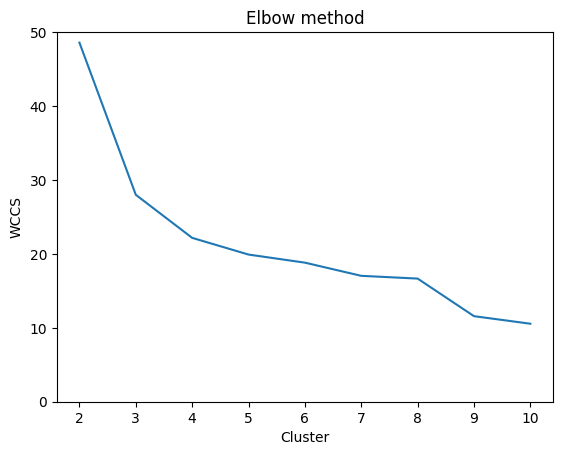

In [19]:
# Eseguiamo l'elbow method per determinare il numero ottimale di cluster
# Lavoriamo sul data frame trasformato con la PCA a due dimensioni
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as pl

wccs = np.zeros(9)

kmeans = KMeans()\
        .setFeaturesCol('features')\
        .setInitMode('k-means||')\
        .setMaxIter(500)\
        .setSeed(42)\
        .setPredictionCol('cluster')

k_values = ParamGridBuilder().addGrid(kmeans.k, [2, 3, 4, 5, 6, 7, 8, 9, 10]).build()

k_models = list(kmeans.fitMultiple(transformed_df[0],k_values))

for k in range(9):
    wccs[k] = k_models[k][1].summary.trainingCost

pl.plot([2, 3, 4, 5, 6, 7, 8, 9, 10],wccs)
pl.ylim(0,50)
pl.xlabel('Cluster')
pl.ylabel('WCCS')
pl.title('Elbow method')
pl.show()
